<a href="https://colab.research.google.com/github/olumideadekunle/week7-non-linear-modeling/blob/main/week7_non_linear_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fliped Cohort

In [1]:
# Install required libraries (run once)
!pip install -q xgboost catboost scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


## Feature Engineering

Creating new features can sometimes significantly improve model performance. Let's create some interaction terms and polynomial features as examples.

In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Example for classification data
# Create interaction terms and polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_clf_poly = poly.fit_transform(X_clf)
print("Original classification shape:", X_clf.shape)
print("Polynomial features classification shape:", X_clf_poly.shape)

# Example for regression data
X_reg_poly = poly.fit_transform(X_reg)
print("Original regression shape:", X_reg.shape)
print("Polynomial features regression shape:", X_reg_poly.shape)

# You would then use these new feature sets (X_clf_poly, X_reg_poly) in your pipelines and model training.
# Remember to apply the same transformations to your test data! You can integrate this into your preprocessing pipeline.

Original classification shape: (569, 30)
Polynomial features classification shape: (569, 495)
Original regression shape: (20640, 8)
Polynomial features regression shape: (20640, 44)


## Additional Evaluation Metrics

Depending on your specific problem, different metrics might be more relevant.

For classification, besides accuracy and ROC AUC, you might consider:
- Precision, Recall, F1-score (already in classification_report)
- Average Precision Score (for imbalanced datasets)

For regression, besides RMSE and R², you might consider:
- Mean Absolute Error (MAE)
- Mean Squared Logarithmic Error (MSLE) - useful when errors are more significant for smaller values.

In [18]:
from sklearn.metrics import average_precision_score, mean_absolute_error, mean_squared_log_error

# Example for classification (using the best performing model from tuning)
best_clf_model = rs_cat.best_estimator_ # Using the tuned CatBoost model as an example
yc_scores = best_clf_model.predict_proba(Xc_test)[:, 1]
avg_precision = average_precision_score(yc_test, yc_scores)
print(f"Classification Average Precision Score: {avg_precision:.4f}")

# Example for regression (using the linear regression baseline for demonstration)
best_reg_model = linr # Using the linear regression model as an example
yr_pred = best_reg_model.predict(Xr_test_scaled) # Use scaled test data for the fitted linear model
mae = mean_absolute_error(yr_test, yr_pred)
# Note: MSLE requires non-negative target and predictions.
# If your target/predictions can be negative, consider adding a small constant or using a different metric.
# For this example, assuming yr_test and yr_pred are suitable:
# msle = mean_squared_log_error(yr_test, yr_pred) # Uncomment if applicable
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
# print(f"Regression Mean Squared Logarithmic Error (MSLE): {msle:.4f}") # Uncomment if applicable

Classification Average Precision Score: 0.9981
Regression Mean Absolute Error (MAE): 0.5332


## Feature Importance

Understanding which features contribute most to your model's predictions can provide valuable insights. Tree-based models like RandomForest and XGBoost provide feature importances.

RandomForest Feature Importances:


,feature,importance
27,worst concave points,0.143201
23,worst area,0.119209
20,worst radius,0.104161
2,mean perimeter,0.089271
0,mean radius,0.069926
7,mean concave points,0.068170
6,mean concavity,0.064504
22,worst perimeter,0.063550
3,mean area,0.056928
13,area error,0.038971


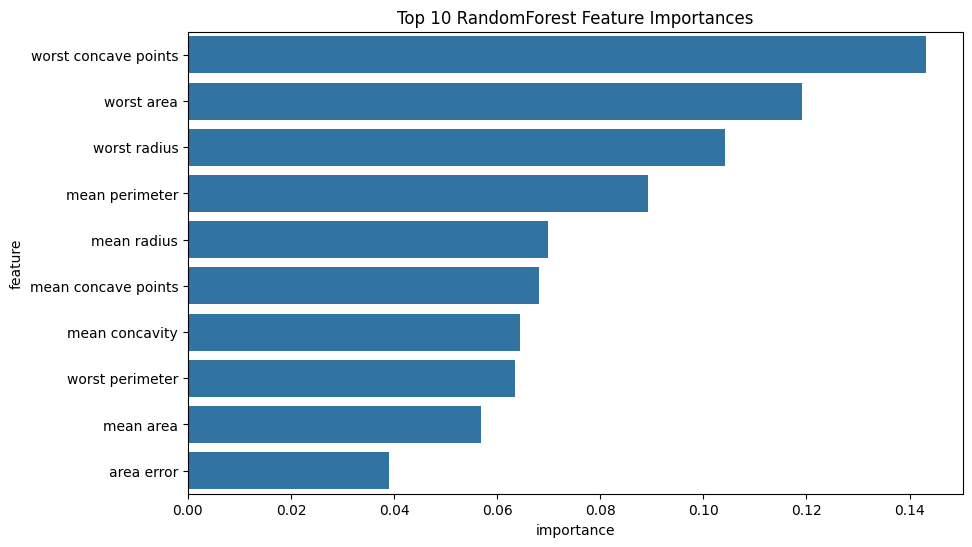

In [19]:
# Example using the tuned RandomForest model
# Access the fitted model from the pipeline
fitted_rf_model = best_rf.named_steps['randomforestclassifier']

# Get feature importances
importances = fitted_rf_model.feature_importances_
features = X_clf.columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("RandomForest Feature Importances:")
display(feature_importance_df)

# You can visualize this with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10)) # Top 10 features
plt.title('Top 10 RandomForest Feature Importances')
plt.show()

# You can do similar analysis for other tree-based models like XGBoost and CatBoost
# For XGBoost: rs_xgb.best_estimator_.named_steps['xgbclassifier'].feature_importances_
# For CatBoost: rs_cat.best_estimator_.named_steps['catboostclassifier'].feature_importances_

In [2]:
from google.colab import drive
drive.mount('/content/drive')  # follow the auth link


Mounted at /content/drive


## Imports + random seed

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error, r2_score

RNG = 42


## Load example datasets (classification & regression)

In [4]:
# Classification example: Breast Cancer (binary)
cancer = load_breast_cancer(as_frame=True)
X_clf = cancer.data
y_clf = cancer.target
print("Classification shape:", X_clf.shape, "Labels distribution:\n", y_clf.value_counts())

# Regression example: California housing
cal = fetch_california_housing(as_frame=True)
X_reg = cal.data
y_reg = cal.target
print("Regression shape:", X_reg.shape)


Classification shape: (569, 30) Labels distribution:
 target
1    357
0    212
Name: count, dtype: int64
Regression shape: (20640, 8)


## Quick EDA (do this for both datasets

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Missing values:
 0


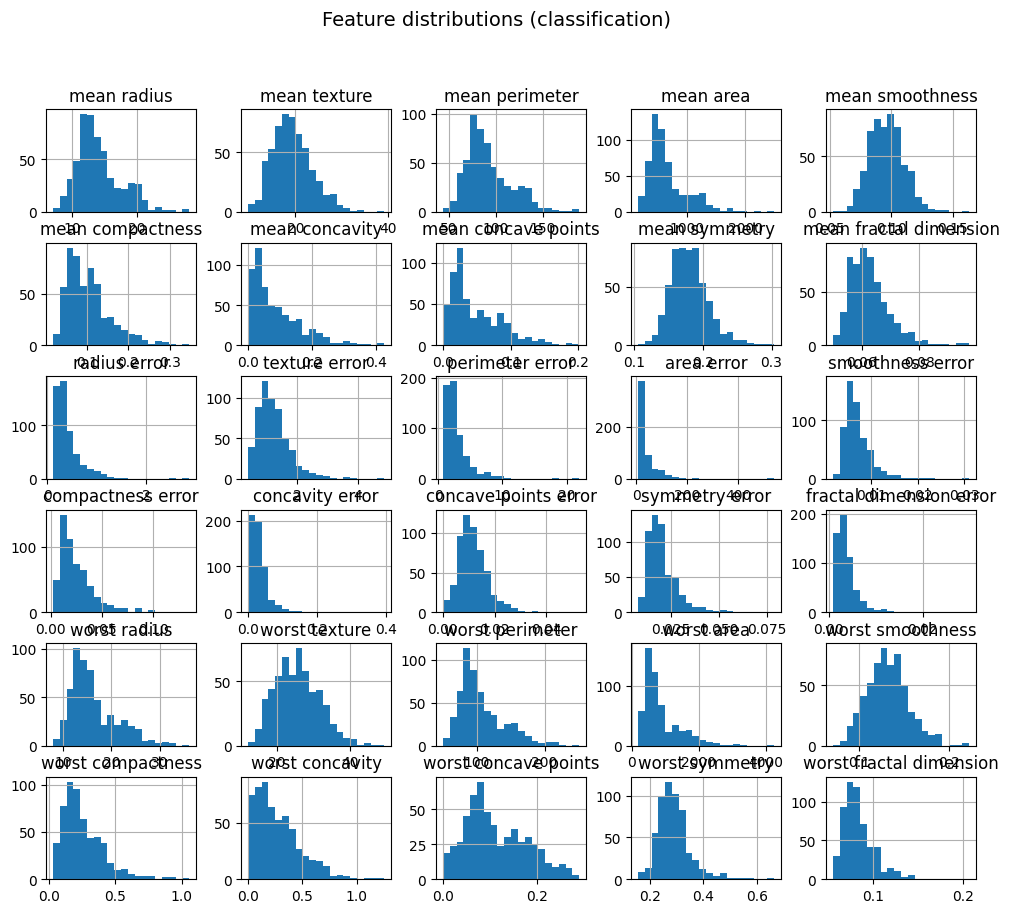

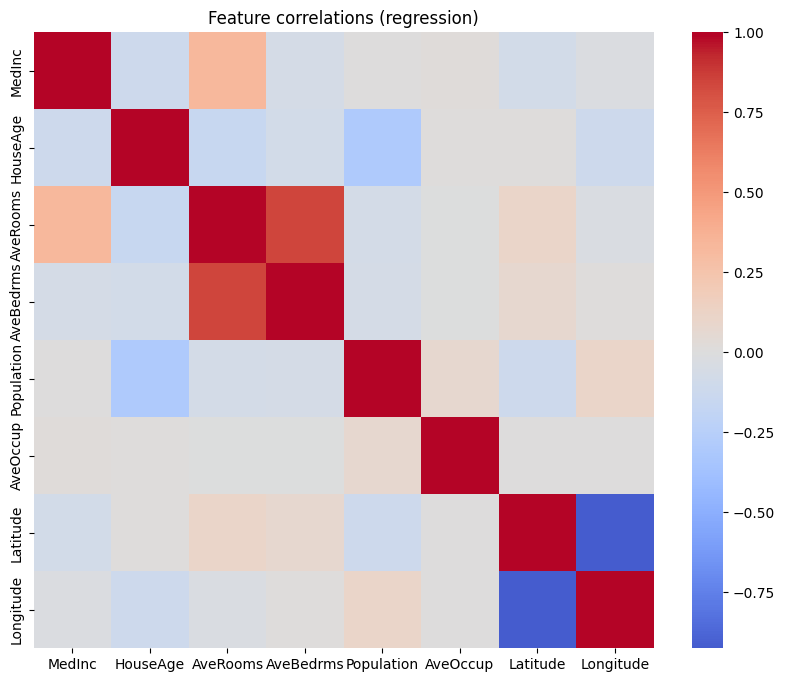

In [6]:
# Example EDA for classification
display(X_clf.head())
display(X_clf.describe().T)
print("Missing values:\n", X_clf.isna().sum().sum())

# Simple plots
X_clf.hist(figsize=(12,10), bins=20)
plt.suptitle('Feature distributions (classification)', fontsize=14)
plt.show()

# Correlation heatmap (regression example)
plt.figure(figsize=(10,8))
sns.heatmap(X_reg.corr(), cmap='coolwarm', center=0)
plt.title('Feature correlations (regression)')
plt.show()


## Look for: missing values, skewed features, class imbalance (for classification), high correlations.

## Preprocessing + train/test split (use Pipelines to avoid leakage)

We use a pipeline that imputes missing values and (optionally) scales.

In [7]:
from sklearn.model_selection import train_test_split

# Classification split (stratify to keep class ratios)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RNG, stratify=y_clf)

# Regression split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RNG)


## This is Basic preprocessing pipeline (While I reuse or adapt it per model):

In [8]:
preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # fills missing values
    ('scaler', StandardScaler())                     # scale numeric features
])
# Fit scaler on training data and transform
Xc_train_scaled = preproc.fit_transform(Xc_train)
Xc_test_scaled  = preproc.transform(Xc_test)

Xr_train_scaled = preproc.fit_transform(Xr_train)
Xr_test_scaled  = preproc.transform(Xr_test)


## Notes: tree-based models (DecisionTree/RandomForest/XGBoost/CatBoost) do not require scaling; linear models benefit from scaling.

## Baseline: Linear models

Classification baseline — Logistic Regression

In [9]:
lr = LogisticRegression(max_iter=5000, random_state=RNG)
lr.fit(Xc_train_scaled, yc_train)
yc_pred = lr.predict(Xc_test_scaled)
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print(classification_report(yc_test, yc_pred))
print("ROC AUC:", roc_auc_score(yc_test, lr.predict_proba(Xc_test_scaled)[:,1]))


Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC: 0.9953703703703703


# This is Regression baseline — Linear Regression

In [10]:
linr = LinearRegression()
linr.fit(Xr_train_scaled, yr_train)
yr_pred = linr.predict(Xr_test_scaled)
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))
print("R2   :", r2_score(yr_test, yr_pred))


RMSE: 0.7455813830127763
R2   : 0.575787706032451


## Record these metrics — they are your linear baseline.

## Non-linear models (default settings)

Train simple versions of each and evaluate. I recommend using Pipelines for safety.

In [11]:
from sklearn.pipeline import make_pipeline

# Classification models
models_clf = {
    'DecisionTree': make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state=RNG)),
    'RandomForest': make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=RNG, n_jobs=-1)),
    'XGBoost': make_pipeline(SimpleImputer(), xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RNG, n_jobs=-1)),
    'CatBoost': make_pipeline(SimpleImputer(), CatBoostClassifier(verbose=0, random_state=RNG))
}

# Train & evaluate quickly
from sklearn.metrics import roc_auc_score
results = []
for name, pipe in models_clf.items():
    pipe.fit(Xc_train, yc_train)
    proba = pipe.predict_proba(Xc_test)[:,1]
    auc = roc_auc_score(yc_test, proba)
    results.append((name, auc))
    print(f"{name}: ROC AUC = {auc:.4f}")


DecisionTree: ROC AUC = 0.9157
RandomForest: ROC AUC = 0.9937
XGBoost: ROC AUC = 0.9901


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:59:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CatBoost: ROC AUC = 0.9950


## I do the Repeat similarly for regression with DecisionTreeRegressor, RandomForestRegressor, xgb.XGBRegressor, CatBoostRegressor and compute RMSE and R².

# While I also use k-fold cross-validation

## Use StratifiedKFold for classification and KFold for regression. Use pipelines so scaling/imputation happens inside each fold (prevents leakage)

In [12]:
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# Example: cross-val for RandomForest
from sklearn.model_selection import cross_val_score
pipe_rf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=RNG, n_jobs=-1))
scores = cross_val_score(pipe_rf, X_clf, y_clf, cv=cv_clf, scoring='roc_auc', n_jobs=-1)
print("RandomForest CV ROC AUC: mean=", scores.mean(), "std=", scores.std())


RandomForest CV ROC AUC: mean= 0.9885484634768126 std= 0.008269216268312597


## While Runinng  all cross_val_score for each algorithm and record means ± std. That tells you stability.

## Checking the Hyperparameter tuning (RandomizedSearchCV example)

Use RandomizedSearchCV (faster than GridSearch). Always wrap the estimator in a Pipeline and use clf__ or reg__ prefix for parameters.

Example: RandomForest (classification)

In [13]:
from scipy.stats import randint
pipe = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=RNG, n_jobs=-1))

param_dist = {
    'randomforestclassifier__n_estimators': [100, 200, 400, 800],
    'randomforestclassifier__max_depth': [None, 5, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.5]
}

rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=cv_clf, n_jobs=-1, random_state=RNG)
rs.fit(Xc_train, yc_train)
print("Best params:", rs.best_params_)
print("Best CV score:", rs.best_score_)
best_rf = rs.best_estimator_
print("Test ROC AUC:", roc_auc_score(yc_test, best_rf.predict_proba(Xc_test)[:,1]))


Best params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 5}
Best CV score: 0.9906088751289991
Test ROC AUC: 0.9917328042328042


## Example: XGBoost (classification)

In [14]:
pipe_xgb = make_pipeline(SimpleImputer(), xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RNG, n_jobs=-1))
param_dist_xgb = {
    'xgbclassifier__n_estimators': [50,100,200,400],
    'xgbclassifier__max_depth': [3,5,7,10],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbclassifier__subsample': [0.6,0.8,1.0],
    'xgbclassifier__colsample_bytree': [0.6,0.8,1.0]
}
rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb, n_iter=25, scoring='roc_auc', cv=cv_clf, n_jobs=-1, random_state=RNG)
rs_xgb.fit(Xc_train, yc_train)
print("XGB best:", rs_xgb.best_params_, "CV:", rs_xgb.best_score_)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.8} CV: 0.9952528379772962


CatBoost tuning (similar structure; CatBoost can be heavy but works fine):

In [15]:
pipe_cat = make_pipeline(SimpleImputer(), CatBoostClassifier(verbose=0, random_state=RNG))
param_dist_cat = {
    'catboostclassifier__iterations': [100, 250, 500],
    'catboostclassifier__depth': [3, 6, 10],
    'catboostclassifier__learning_rate': [0.01, 0.05, 0.1]
}
rs_cat = RandomizedSearchCV(pipe_cat, param_distributions=param_dist_cat, n_iter=12, scoring='roc_auc', cv=cv_clf, n_jobs=-1, random_state=RNG)
rs_cat.fit(Xc_train, yc_train)
print("CatBoost best:", rs_cat.best_params_, "CV:", rs_cat.best_score_)


CatBoost best: {'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__iterations': 100, 'catboostclassifier__depth': 6} CV: 0.993498452012384


## Collect & compare results

Create a small results table:

In [16]:
comparison = []

# Evaluate a fitted model (example)
def eval_clf(name, model, Xtest, ytest):
    proba = model.predict_proba(Xtest)[:,1]
    auc = roc_auc_score(ytest, proba)
    comparison.append({'model': name, 'roc_auc': auc})

# Example: add baseline and best RF/XGB/CatBoost
eval_clf('LogisticRegression', lr, Xc_test_scaled, yc_test)
eval_clf('RandomForest (tuned)', best_rf, Xc_test, yc_test)   # best_rf comes from RandomizedSearchCV
eval_clf('XGBoost (tuned)', rs_xgb.best_estimator_, Xc_test, yc_test)
eval_clf('CatBoost (tuned)', rs_cat.best_estimator_, Xc_test, yc_test)

pd.DataFrame(comparison).sort_values('roc_auc', ascending=False)


,model,roc_auc
3,CatBoost (tuned),0.996693
0,LogisticRegression,0.995370
2,XGBoost (tuned),0.994709
1,RandomForest (tuned),0.991733


## What to look for

Did CV scores improve after tuning? (compare CV mean scores)

Does test performance match CV performance? If test << CV, you may be overfitting.

Feature importances: model.named_steps['randomforestclassifier'].feature_importances_ (extract from pipeline)

## Ensemble Methods

Combining the predictions of multiple models can often lead to improved performance and robustness. A simple approach is to average the probabilities predicted by different models (for classification) or average the predicted values (for regression).

Let's create an ensemble of our best classification models (Logistic Regression, Tuned XGBoost, and Tuned CatBoost) by averaging their predicted probabilities.

In [20]:
# Get the best fitted models from the tuning steps
# Logistic Regression (already fitted)
lr_clf = lr

# Tuned XGBoost
xgb_clf = rs_xgb.best_estimator_

# Tuned CatBoost
cat_clf = rs_cat.best_estimator_

# Get predicted probabilities from each model on the test set
lr_proba = lr_clf.predict_proba(Xc_test_scaled)[:, 1] # Use scaled data for LR
xgb_proba = xgb_clf.predict_proba(Xc_test)[:, 1] # Use unscaled data for XGBoost/CatBoost
cat_proba = cat_clf.predict_proba(Xc_test)[:, 1]

# Simple Averaging Ensemble: Average the probabilities
ensemble_proba = (lr_proba + xgb_proba + cat_proba) / 3

# Evaluate the ensemble using ROC AUC
ensemble_auc = roc_auc_score(yc_test, ensemble_proba)
print(f"Ensemble (Averaging) ROC AUC: {ensemble_auc:.4f}")

# You can also compare this to the individual model scores again for clarity
print("\nIndividual Model ROC AUCs on Test Set:")
print(f"Logistic Regression: {roc_auc_score(yc_test, lr_proba):.4f}")
print(f"XGBoost (tuned): {roc_auc_score(yc_test, xgb_proba):.4f}")
print(f"CatBoost (tuned): {roc_auc_score(yc_test, cat_proba):.4f}")

# To make predictions with the ensemble, you would typically set a threshold (e.g., 0.5)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)
print("\nEnsemble Classification Report:")
print(classification_report(yc_test, ensemble_pred))

Ensemble (Averaging) ROC AUC: 0.9954

Individual Model ROC AUCs on Test Set:
Logistic Regression: 0.9954
XGBoost (tuned): 0.9947
CatBoost (tuned): 0.9967

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [21]:
from google.colab import files
files.download('your_notebook.ipynb')
files.download('model.joblib')


FileNotFoundError: Cannot find file: your_notebook.ipynb

In [22]:
import joblib

# Assuming 'best_clf_model' is your trained model
joblib.dump(best_clf_model, 'best_classification_model.joblib')

# Now you can download the saved model file
from google.colab import files
files.download('best_classification_model.joblib')

# You can also download the notebook file if you know its name
# files.download('Your_Notebook_Name.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# create and enter project folder (or move your downloaded files here)
!mkdir week7-non-linear-modeling
!cd week7-non-linear-modeling
# copy your downloaded notebook and other files into this folder
#!cp your_notebook_name.ipynb ./
#!cp best_classification_model.joblib ./

In [26]:
!git init
!git config --global user.name "Your Name"
!git config --global user.email "youremail@example.com"

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [28]:
!git branch -M main
!git remote add origin https://github.com/<USERNAME>/<REPO>.git
!git push -u origin main

/bin/bash: line 1: USERNAME: No such file or directory
error: src refspec main does not match any
error: failed to push some refs to 'origin'


In [30]:
!git branch -M main
!git remote add origin https://github.com/<USERNAME>/<REPO>.git
!git push -u origin main

/bin/bash: line 1: USERNAME: No such file or directory
error: src refspec main does not match any
error: failed to push some refs to 'origin'


In [33]:
!git add .
!git commit -m "Add Colab notebook and scripts"
!git push

error: open("drive/MyDrive/APPLICATION PROCESS -.gdoc"): Operation not supported
error: unable to index file 'drive/MyDrive/APPLICATION PROCESS -.gdoc'
fatal: adding files failed
On branch main

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	best_classification_model.joblib
	catboost_info/
	drive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
fatal: No configured push destination.
Either specify the URL from the command-line or configure a remote repository using

    git remote add <name> <url>

and then push using the remote name

    git push <name>

